# 01. Baixando Dataset

O primeiro passo é baixar o dataset. 

O repositório aponta para o link no Google Drive
https://drive.google.com/file/d/1VYuxtIjM5tMCzduyCQrc5L_msXmtJq5U/view?usp=sharing

 arquivo possui 191G e é composto por vários PCAPs com a captura de tráfego de rede. Além disso, o o zip possui vários arquivos placeholders.


Demorou cercade de 2 horas para baixar.

In [1]:
!ls -lah ../Data.zip

-rw-rw-r-- 1 diogo diogo 191G abr 16 13:31 ../Data.zip


A árvore que ele descomprime é grande, mas de início tem vários arquivos vazios que parecem ser só para marcar o espaço, placeholders.

Focando nas pastas com PCAPs temos o seguninte


```
Data
├── [proximity, coarse, fine_grained]   → São os 3 testes.
├──── [Classroom, Office]               → O lugar onde foi realizada a coleta.
├────── 80MHz/3mo                       → largura de banda e quantidade de monitores.
├──────── [m1, m2, m3]                  → medicões de cada monitor.
├────────── CSI_pcap                    → onde estão os arquivos .pcap.
```


Do arquivo README.md

> We captured the IEEE 802.11ac CSI pcap files with 80MHz bandwidth for **three different Tests**: <br/>
> **(I) proximity_test**: We address the simultaneous multi-subject classification issue by using the Channel State Information (CSI) computed from the device positioned closest to the subject. We experimentally prove this intuition by confirming that the best accuracy is experienced when the CSI computed by the transceiver positioned closest to the subject is used for classification. We call this **Proximity Test.** <br/>
>
> **(II) coarse_detection**: Now, we move on to the simultaneous sensing. To tackle the challenge of scalability, we propose decentralized detection. Specifically, a learning model is assigned to each device to sense the subject which is closest to it. We call this coarse detection. (**subject identification**) <br/>
>
> **(III) fine_grained**: After the coarse detection, another fine-grained DL model is used to determine the activities. 


In [4]:
!find ../Data -type d -name CSI_pcap | while read dir; do     count=$(find "$dir" -maxdepth 1 -name '*.pcap' | wc -l);     total_bytes=$(find "$dir" -maxdepth 1 -name '*.pcap' -exec du -bc {} + | grep total$ | awk '{print $1}');     if [ "$count" -gt 0 ]; then         avg_bytes=$((total_bytes / count));         avg_human=$(numfmt --to=iec --suffix=B "$avg_bytes");         total_human=$(numfmt --to=iec --suffix=B "$total_bytes");     else         avg_human="N/A";         total_human="0B";     fi;     BLUE='\033[1;34m';     GREEN='\033[1;32m';     YELLOW='\033[1;33m';     MAGENTA='\033[1;35m';     NC='\033[0m' ;     echo -e "${BLUE}$dir${NC} -> ${GREEN}$count arquivos${NC}, ${YELLOW}Total: $total_human${NC}, ${MAGENTA}Média: $avg_human${NC}"; done

../Data/coarse/Classroom/80MHz/3mo/m2/CSI_pcap -> 4 arquivos, Total: 1,7GB, Média: 421MB
../Data/coarse/Classroom/80MHz/3mo/m3/CSI_pcap -> 4 arquivos, Total: 1,7GB, Média: 423MB
../Data/coarse/Classroom/80MHz/3mo/m1/CSI_pcap -> 4 arquivos, Total: 1,7GB, Média: 420MB
../Data/coarse/Office/80MHz/3mo/m2/CSI_pcap -> 4 arquivos, Total: 1,8GB, Média: 458MB
../Data/coarse/Office/80MHz/3mo/m3/CSI_pcap -> 4 arquivos, Total: 1,7GB, Média: 428MB
../Data/coarse/Office/80MHz/3mo/m1/CSI_pcap -> 4 arquivos, Total: 1,7GB, Média: 432MB
../Data/proximity/Classroom/80MHz/3mo/m2/CSI_pcap -> 20 arquivos, Total: 14GB, Média: 704MB
../Data/proximity/Classroom/80MHz/3mo/m3/CSI_pcap -> 20 arquivos, Total: 15GB, Média: 727MB
../Data/proximity/Classroom/80MHz/3mo/m1/CSI_pcap -> 20 arquivos, Total: 14GB, Média: 710MB
../Data/proximity/Office/80MHz/3mo/m2/CSI_pcap -> 20 arquivos, Total: 23GB, Média: 1,2GB
../Data/proximity/Office/80MHz/3mo/m3/CSI_pcap -> 20 arquivos, Total: 22GB, Média: 1,1GB
../Data/proximity/Off

Caminho | Arquivos | Tamanho Total | Tamanho Médio
--- | --- | --- | ---
proximity / Classroom / m[1-3] | 20 arquivos | ~14-15 GB | ~704-727 MB
proximity / Office / m[1-3] | 20 arquivos | ~22-23 GB | ~1.1-1.2 GB
coarse / Classroom / m[1-3] | 4 arquivos | ~1.7 GB | ~420 MB
coarse / Office / m[1-3] | 4 arquivos | ~1.7-1.8 GB | ~430-458 MB
fine_grained / Classroom / m[1-3] | 20 arquivos | ~14-15 GB | ~704-727 MB
fine_grained / Office / m[1-3] | 20 arquivos | ~22-23 GB | ~1.1-1.2 GB

O testes "proximity" e "fine_grained" possuem 20 PCAPs, nomeados como A.pcap, B.pcap, ..., T.pcap. Acredito que cada letra identifica uma das 20 atividades.

Já o teste "coarse" possui apenas 4 PCAPs A.pcap, ..., D.pcap, indicando que o modelo de identificação do índividuo não precisou ser treinado com todas as atividades.

Além disso o tamanho dos arquivos PCAPs é diferente. Provavelmente indicando o tempo de captura. 

Os tamanhos totais dos arquivos dentro "proximity" e "fine-grained" parecem iguais.
Será que são os mesmo arquivos? Resposta Não são


In [16]:
!du -sc ../Data/fine_grained/Classroom/80MHz/3mo/m1/
!du -sc ../Data/proximity/Classroom/80MHz/3mo/m1/

14528724	../Data/fine_grained/Classroom/80MHz/3mo/m1/
14528724	total
14529056	../Data/proximity/Classroom/80MHz/3mo/m1/
14529056	total


In [6]:
from scapy.all import RawPcapReader
import os
from datetime import datetime
from tqdm import tqdm

def summarize_pcap(file_path, verbose=False):
    # Get size of pcap file in bytes
    try:
        file_size_bytes = os.path.getsize(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return

    try:
        reader = RawPcapReader(file_path)
    except Exception as e:
        print(f"Error opening pcap: {e}")
        return

    num_packets = 0
    start_time = None
    end_time = None

    for pkt_data, pkt_metadata in reader:
        ts = pkt_metadata.sec + pkt_metadata.usec / 1_000_000
        if start_time is None:
            start_time = ts
        end_time = ts
        num_packets += 1

    reader.close()

    if num_packets == 0:
        print("No packets found in the file.")
        return

    # Convert timestamps to readable format
    start_dt = datetime.fromtimestamp(start_time)
    end_dt = datetime.fromtimestamp(end_time)
    duration = end_time - start_time

    # Convert bytes to megabytes
    file_size_mb = file_size_bytes / (1024 * 1024)

    if verbose:
        print("📄 PCAP Summary:")
        print(f"- Number of packets: {num_packets}")
        print(f"- Start time       : {start_dt}")
        print(f"- End time         : {end_dt}")
        print(f"- Duration         : {duration:.6f} seconds")
        print(f"- File size        : {file_size_mb:.2f} MB")

    return (num_packets, start_dt, end_dt, duration, file_size_mb)


In [6]:
!ls ../Data/coarse/Classroom/80MHz/3mo/m2/CSI_pcap

A.pcap	B.pcap	C.pcap	D.pcap


In [7]:
# Example usage
file_path = "../Data/coarse/Classroom/80MHz/3mo/m2/CSI_pcap/A.pcap" 
num_packets, start_dt, end_dt, duration, file_size_mb = summarize_pcap(file_path, verbose=True)

📄 PCAP Summary:
- Number of packets: 400604
- Start time       : 2018-05-05 04:41:20.467729
- End time         : 2018-05-05 04:46:30.719364
- Duration         : 310.251635 seconds
- File size        : 420.25 MB


In [8]:
# Example usage
file_path = "../Data/coarse/Classroom/80MHz/3mo/m2/CSI_pcap/A.pcap" 
num_packets, start_dt, end_dt, duration, file_size_mb = summarize_pcap(file_path, verbose=True)

📄 PCAP Summary:
- Number of packets: 400604
- Start time       : 2018-05-05 04:41:20.467729
- End time         : 2018-05-05 04:46:30.719364
- Duration         : 310.251635 seconds
- File size        : 420.25 MB


In [9]:
from pathlib import Path
from tqdm import tqdm

df_proto = {
    'file_path': [],
    'num_packets': [],
    'start_time': [],
    'end_time': [],
    'duration': [],
    'file_size_mb': []
}

file_paths = Path('../Data').rglob('*.pcap')

for file_path in tqdm(sorted(file_paths)):
  file_path = str(file_path)
  num_packets, start_dt, end_dt, duration, file_size_mb  = summarize_pcap(file_path)
  df_proto['file_path'].append(file_path)
  df_proto['num_packets'].append(num_packets)
  df_proto['start_time'].append(start_dt)
  df_proto['end_time'].append(end_dt)
  df_proto['duration'].append(duration)
  df_proto['file_size_mb'].append(file_size_mb)   


100%|██████████| 264/264 [05:55<00:00,  1.35s/it]


In [13]:
import pandas as pd

df = pd.DataFrame(df_proto)
df.head()


,file_path,num_packets,start_time,end_time,duration,file_size_mb
0,../Data/coarse/Classroom/80MHz/3mo/m1/CSI_pcap...,397780,2018-05-05 04:08:53.974579,2018-05-05 04:14:04.204180,310.229601,417.287849
1,../Data/coarse/Classroom/80MHz/3mo/m1/CSI_pcap...,390882,2018-05-05 04:17:39.777768,2018-05-05 04:22:50.032895,310.255127,410.051559
2,../Data/coarse/Classroom/80MHz/3mo/m1/CSI_pcap...,402670,2018-05-05 04:33:40.558963,2018-05-05 04:38:50.808146,310.249183,422.417664
3,../Data/coarse/Classroom/80MHz/3mo/m1/CSI_pcap...,409930,2018-05-05 04:25:53.864638,2018-05-05 04:31:04.118338,310.253700,430.033707
4,../Data/coarse/Classroom/80MHz/3mo/m2/CSI_pcap...,400604,2018-05-05 04:41:20.467729,2018-05-05 04:46:30.719364,310.251635,420.250343


In [14]:
df.to_csv('SAIDAS/01-pcap_summary.csv', index=False)

In [15]:
df.describe()

,num_packets,start_time,end_time,duration,file_size_mb
count,2.640000e+02,264,264,264.000000,264.000000
mean,8.292726e+05,2018-05-05 07:37:44.794411008,2018-05-05 07:50:42.135842816,777.341432,869.941587
min,3.217780e+05,2018-05-05 02:18:01.914463,2018-05-05 02:31:40.964911,273.926298,337.558578
25%,4.623090e+05,2018-05-05 04:58:39.680390912,2018-05-05 05:12:23.275682304,819.108019,484.981464
50%,1.004204e+06,2018-05-05 07:50:55.436413952,2018-05-05 08:04:37.582631424,819.262031,1053.452467
75%,1.076332e+06,2018-05-05 10:19:42.069700096,2018-05-05 10:33:22.796084736,825.163424,1129.117226
max,1.212282e+06,2018-05-05 13:35:05.663228,2018-05-05 13:48:44.733418,827.274921,1271.734451
std,2.987440e+05,NaN,NaN,142.439527,313.394939


In [2]:
import pandas as pd 
df = pd.read_csv('SAIDAS/01-pcap_summary.csv')

In [25]:
def process_df(row):
  file_path = row['file_path']
  file_path_splited = file_path.split('/')
  row['test'] = file_path_splited[2]
  row['environment'] = file_path_splited[3]
  row['monitor'] = file_path_splited[6]
  row['activity'] = file_path_splited[8].split('.')[0]
  return row


df = df.apply(process_df, axis=1)
df.to_csv('SAIDAS/01-pcap_summary.csv', index=False)

In [29]:
# max, min, mean, median duration for each test, environment, monitor, activity
df.groupby(['test', 'environment'])['duration'].agg(['max', 'min', 'mean', 'median']).reset_index()

,test,environment,max,min,mean,median
0,coarse,Classroom,310.257513,305.021744,309.814010,310.252667
1,coarse,Office,412.448505,273.926298,349.148396,355.110003
2,fine_grained,Classroom,819.272738,819.034280,819.151165,819.134385
3,fine_grained,Office,827.274921,820.017967,825.103744,825.178221
4,proximity,Classroom,819.272738,819.034280,819.151165,819.134385
5,proximity,Office,827.274921,820.017967,825.103744,825.178221


In [36]:
df.groupby(['activity','test', 'environment'])['duration'].agg(['max', 'min', 'mean', 'median']).reset_index()

,activity,test,environment,max,min,mean,median
0,A,coarse,Classroom,310.256251,310.229601,310.245829,310.251635
1,A,coarse,Office,412.445361,273.928290,347.160278,355.107183
2,A,fine_grained,Classroom,819.230593,819.079725,819.160022,819.169747
3,A,fine_grained,Office,825.245677,822.119236,824.164730,825.129276
4,A,proximity,Classroom,819.230593,819.079725,819.160022,819.169747
...,...,...,...,...,...,...,...
83,S,proximity,Office,825.184821,825.156095,825.166773,825.159403
84,T,fine_grained,Classroom,819.112251,819.108806,819.111103,819.112251
85,T,fine_grained,Office,825.190964,825.153324,825.177327,825.187692
86,T,proximity,Classroom,819.112251,819.108806,819.111103,819.112251


Resumo
- São 264 PCAPs.
- Todas as capturas ocorreram no dia 05/05/2018, um sábado. Das 02:18 às 13:48.
- A duração vária entre tipo de testes e ambientes. 
  - As capturas das atividades nos testes Proximity e Fine-grained vão de 13'10'' no Classroom a 13'50'' no Office.
  - As capturas das atividades no teste Coarse vai de 4'30' no Office a 5'05'' 6'5'' também no Office;
- Não há variação entre tempo de captura entre os diferentes monitores.
- 264 PCAPs
  - Para 2 testes (Proximity, Fine-grained)
    - 2 Ambientes (Classroom e Office)
      - 3 monitores 
        - 20 atividades
  

Para os testes (Proximity, Fine-grained), 2 ambientes, 3 monitores e 20 atividades, temos = 2*2*3*20 = 240 PCAPs

Para o  teste (Coarse), 2 ambientes, 3 monitores e 4 atividades, temos = 1*2*3*4 = 24 PCAPs


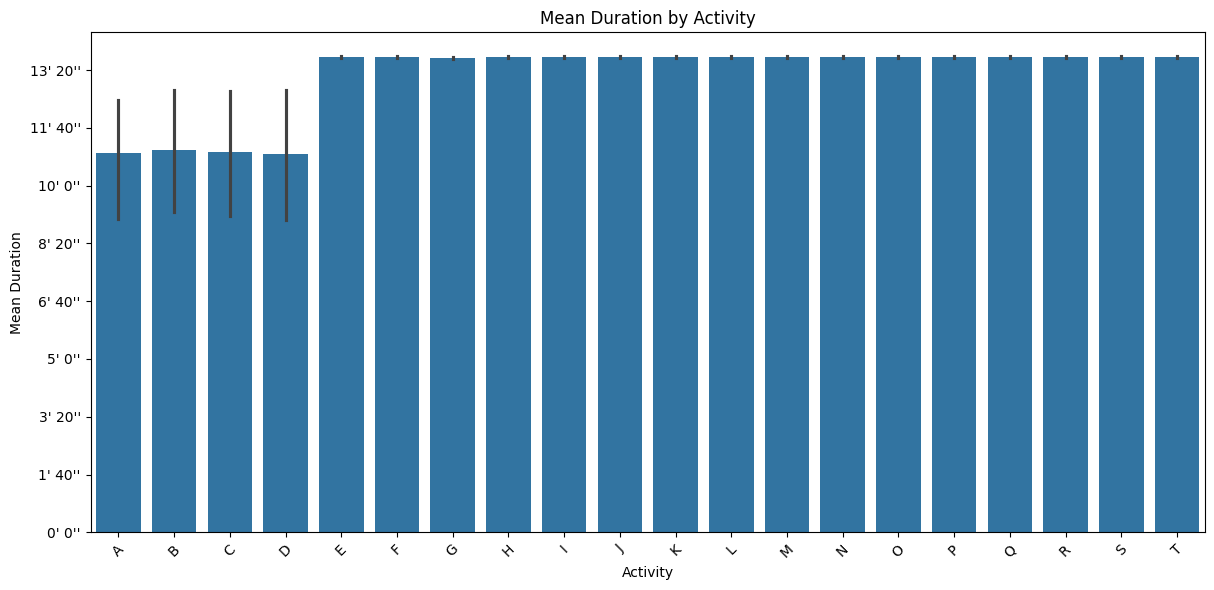

In [51]:
# plot duration by activity in a bar plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.dates as mdates


def plot_duration_by_activity(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='activity', y='duration', data=df, estimator='mean')
    plt.xticks(rotation=45)
    plt.title('Mean Duration by Activity')
    plt.xlabel('Activity')
    plt.ylabel('Mean Duration')
    plt.tight_layout()
    # Set y-axis to a format {minutes}' seconds''
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x // 60)}' {int(x % 60)}''"))
    plt.show()

plot_duration_by_activity(df)


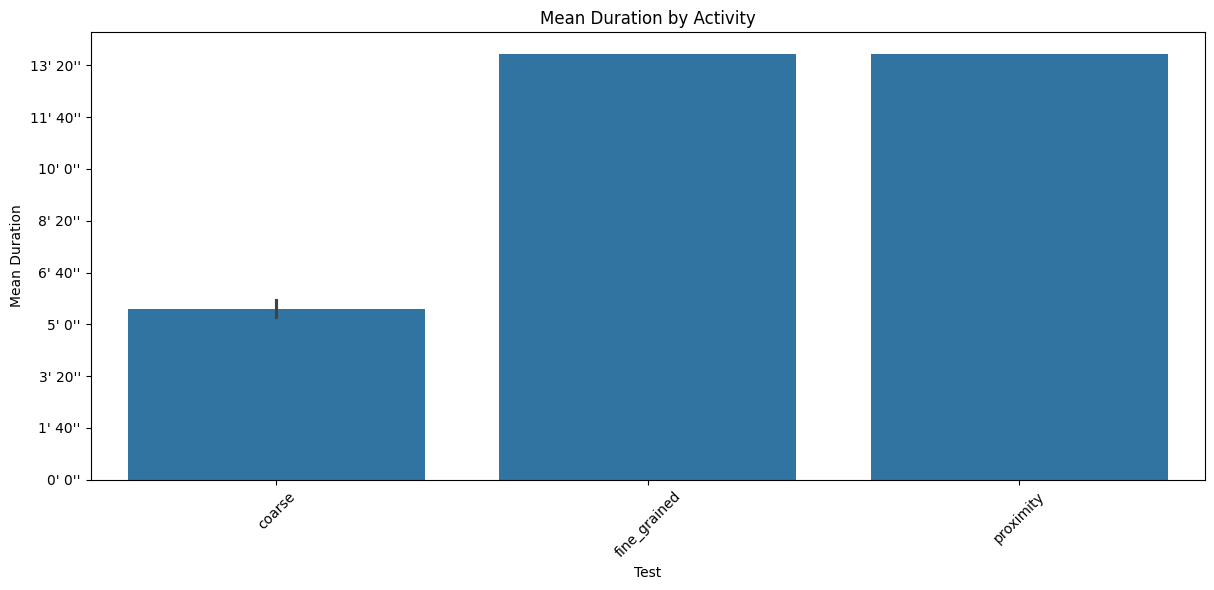

In [52]:

def plot_duration_by_test(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='test', y='duration', data=df, estimator='mean')
    plt.xticks(rotation=45)
    plt.title('Mean Duration by Activity')
    plt.xlabel('Test')
    plt.ylabel('Mean Duration')
    plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x // 60)}' {int(x % 60)}''"))

    plt.show()

plot_duration_by_test(df)

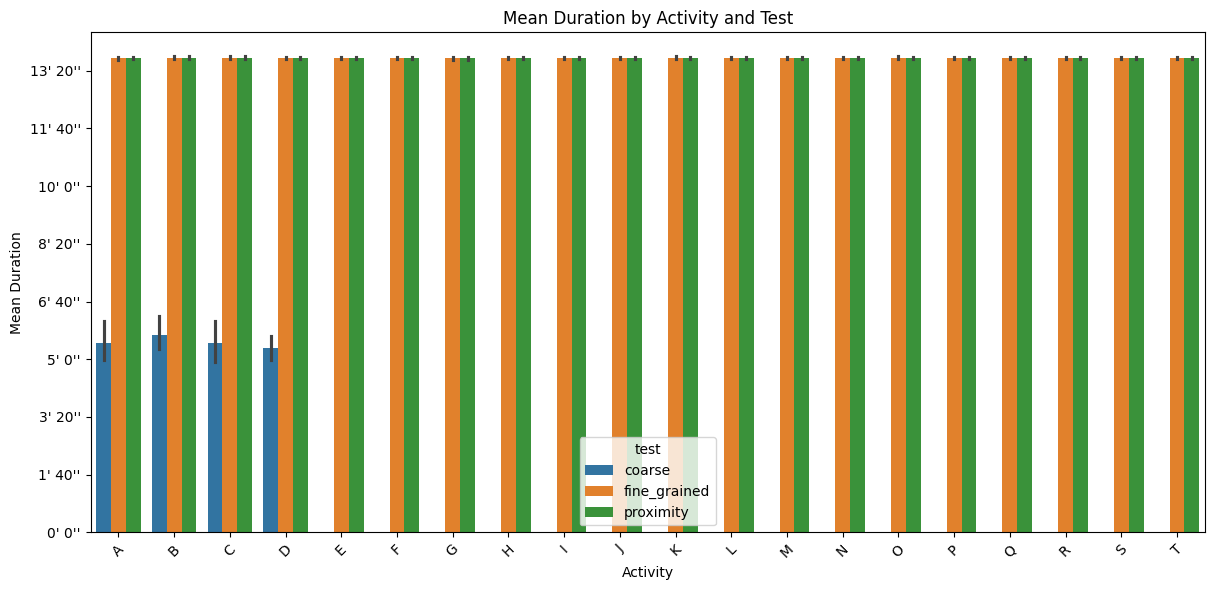

In [53]:
# for duration by activity and test
def plot_duration_by_activity_and_test(df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='activity', y='duration', hue='test', data=df, estimator='mean')
    plt.xticks(rotation=45)
    plt.title('Mean Duration by Activity and Test')
    plt.xlabel('Activity')
    plt.ylabel('Mean Duration')
    plt.tight_layout()
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x // 60)}' {int(x % 60)}''"))

    plt.show()

plot_duration_by_activity_and_test(df)

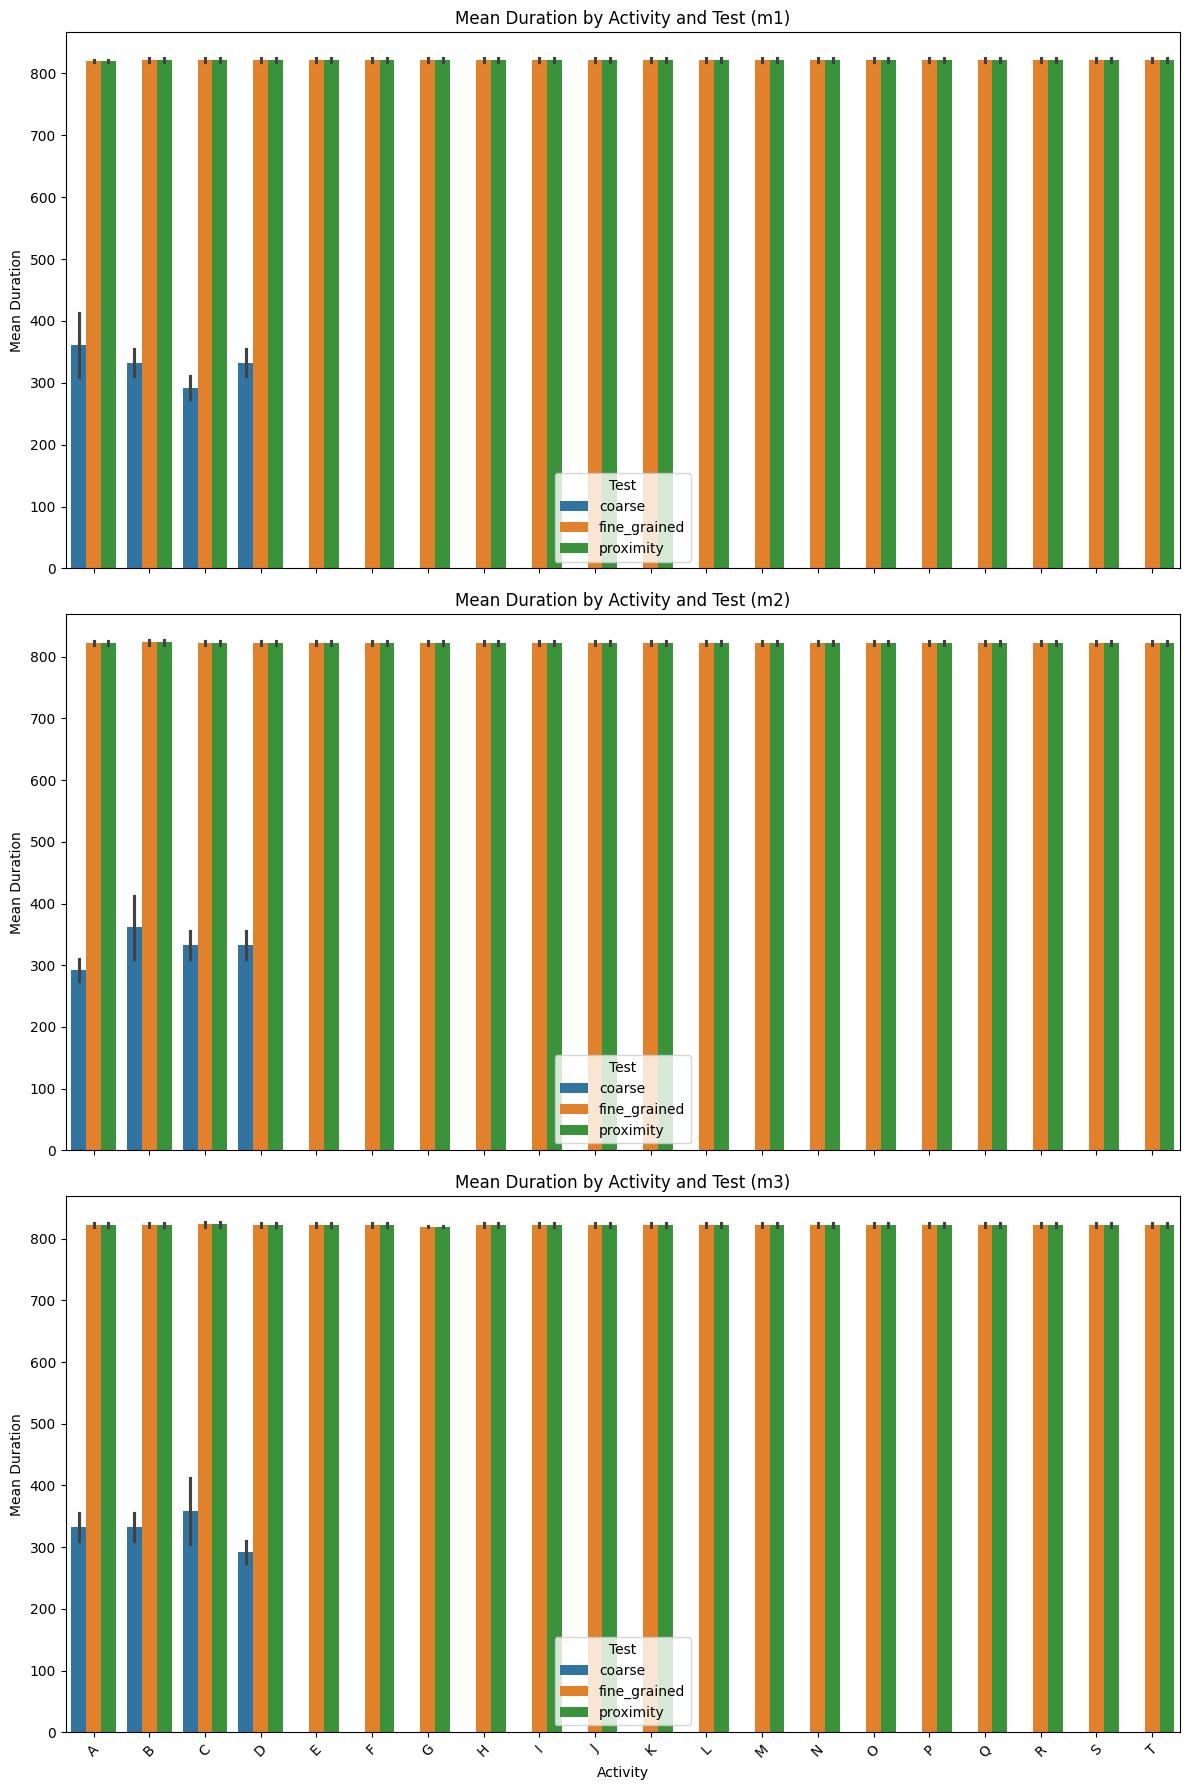

In [54]:
# for duration by activity and test, plot subplots for each monitor
def plot_duration_by_activity_and_test(df):
    monitors = df['monitor'].unique()
    num_monitors = len(monitors)
    
    fig, axes = plt.subplots(num_monitors, 1, figsize=(12, 6 * num_monitors), sharex=True)
    
    for i, monitor in enumerate(monitors):
        ax = axes[i]
        sns.barplot(x='activity', y='duration', hue='test', data=df[df['monitor'] == monitor], estimator='mean', ax=ax)
        ax.set_title(f'Mean Duration by Activity and Test ({monitor})')
        ax.set_xlabel('Activity')
        ax.set_ylabel('Mean Duration')
        ax.legend(title='Test')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
plot_duration_by_activity_and_test(df)


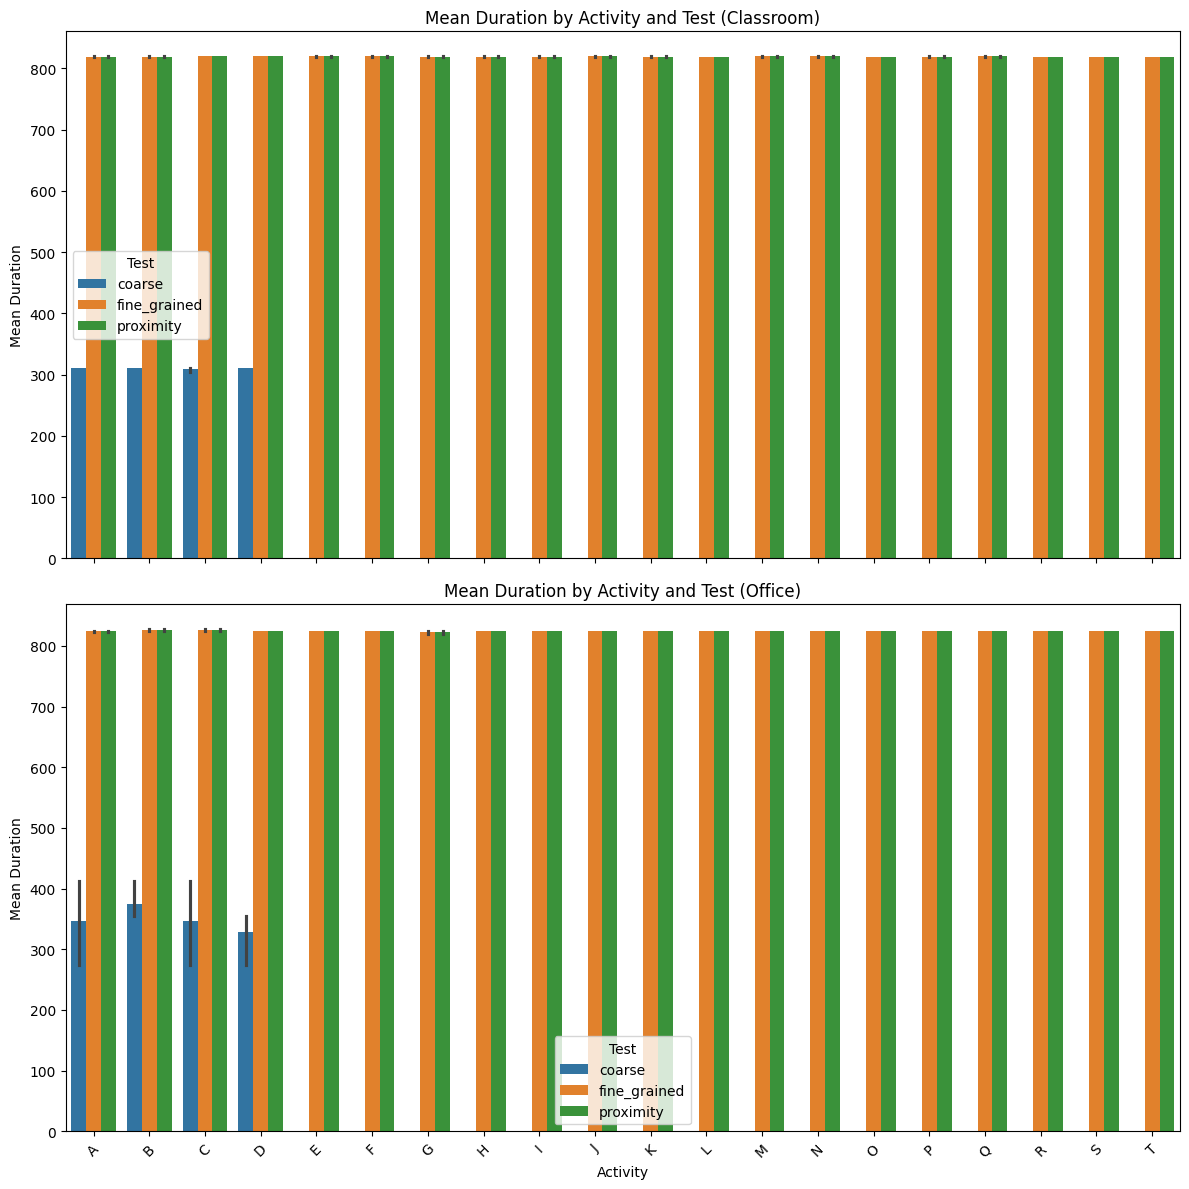

In [55]:
# for duration by activity and test, plot subplots for each monitor
def plot_duration_by_activity_and_test_and_environment(df):
    environments = df['environment'].unique()
    num_environments = len(environments)
    
    fig, axes = plt.subplots(num_environments, 1, figsize=(12, 6 * num_environments), sharex=True)
    
    for i, environment in enumerate(environments):
        ax = axes[i]
        sns.barplot(x='activity', y='duration', hue='test', data=df[df['environment'] == environment], estimator='mean', ax=ax)
        ax.set_title(f'Mean Duration by Activity and Test ({environment})')
        ax.set_xlabel('Activity')
        ax.set_ylabel('Mean Duration')
        ax.legend(title='Test')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
plot_duration_by_activity_and_test_and_environment(df)
